# Задача 4. Ансамбли

- Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import pathlib
from sklearn.preprocessing import LabelEncoder

%precision % .4f

import warnings

warnings.filterwarnings('ignore')  
dataset_path = "/content/dataset/fipe_2022.csv"

# Датасет
Используется [датасет](https://www.kaggle.com/datasets/vagnerbessa/average-car-prices-bazil), демонстрирующий средние цены на автомобили, проданные в Бразилии за последние 2 года (янв 2021 - янв 2023).

Решается задача регрессии: определение цены машины

In [240]:
df = pd.read_csv(dataset_path, nrows=10000)

# 0. Preparing data

In [241]:
df.head()

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,age_years
0,2022,January,038001-6,vwmrywl5qs,Acura,NSX 3.0,Gasoline,manual,3.0,1995,43779.0,28
1,2022,January,038001-6,t9mt723qhz,Acura,NSX 3.0,Gasoline,manual,3.0,1994,42244.0,29
2,2022,January,038001-6,tr5wv4z21g,Acura,NSX 3.0,Gasoline,manual,3.0,1993,40841.0,30
3,2022,January,038001-6,s2xxsjz3mt,Acura,NSX 3.0,Gasoline,manual,3.0,1992,39028.0,31
4,2022,January,038001-6,rtm9gj7zk8,Acura,NSX 3.0,Gasoline,manual,3.0,1991,35678.0,32


In [242]:
df.isna().sum()

year_of_reference     0
month_of_reference    0
fipe_code             0
authentication        0
brand                 0
model                 0
fuel                  0
gear                  0
engine_size           0
year_model            0
avg_price_brl         0
age_years             0
dtype: int64

Null значения отсутствуют

In [243]:
print("Число записей и параметров ", df.shape)

Число записей и параметров  (10000, 12)


Имена параметров:


In [244]:
df.columns

Index(['year_of_reference', 'month_of_reference', 'fipe_code',
       'authentication', 'brand', 'model', 'fuel', 'gear', 'engine_size',
       'year_model', 'avg_price_brl', 'age_years'],
      dtype='object')

Удалим ненужные параметры:

In [245]:
df.drop(["fipe_code", "authentication"], axis=1, inplace=True)
df.columns

Index(['year_of_reference', 'month_of_reference', 'brand', 'model', 'fuel',
       'gear', 'engine_size', 'year_model', 'avg_price_brl', 'age_years'],
      dtype='object')

# 1. EDA

Изобразим распределение по ключевым числовым признакам:

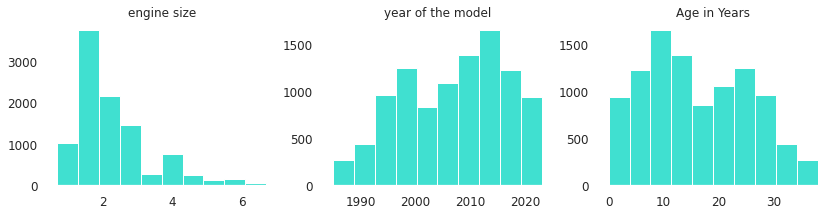

In [246]:
sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':12,'ytick.labelsize':12})
fig, axes = plt.subplots(1, 3, figsize=(14,3))
year_model = df.year_model.hist(ax=axes[1], color="#40E0D0", grid=False, ).set_title('year of the model')
age_years = df.age_years.hist(ax=axes[2], color="#40E0D0", grid=False).set_title('Age in Years')
engine_size = df.engine_size.hist(ax=axes[0], color="#40E0D0", grid=False).set_title('engine size')

Наблюдаем, что "year_model" и "age_years" обратно пропорциональны

Text(0.5, 1.0, 'Correlation Heatmap')

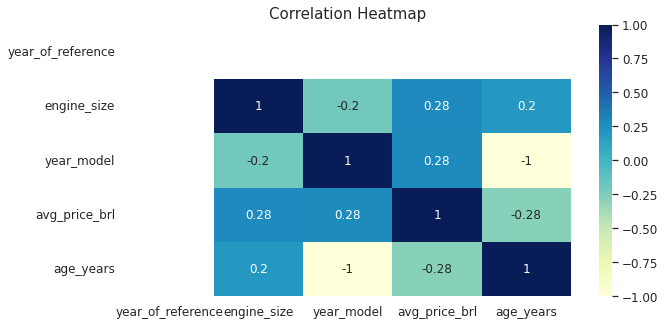

In [247]:
plt.figure(figsize=(10,5))
corr = df.corr(method='pearson').round(4)
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontdict={'fontsize':15})

как было замечено выше "year_model" и "age_years" обратно пропорциональны, поэтмому удалим один из этих параметров 

In [248]:
df.drop('year_model', axis=1, inplace=True)

In [249]:
cat_df = df[['month_of_reference', 'brand', 'model', 'fuel', 'gear']]
num_df = df[['engine_size', 'avg_price_brl', 'age_years']]

In [250]:
le = LabelEncoder ()

#select ctegorical columns 
cat_df = df.select_dtypes(exclude=["int", "float"])

for i in cat_df:
    cat_df[i] = le.fit_transform(df[i])

#joining the data to the numeric data
num_df = df.select_dtypes(include=['int', 'float'])
main_df = pd.concat([num_df, cat_df], axis=1)

In [251]:
# Segregating the Dependent Variable in Y-axis and Independent Variables in X-axis
X = main_df.drop(columns=["avg_price_brl"])
Y = main_df["avg_price_brl"]

# Implementation of Bagging and AdaBoost regressors

In [252]:
import sklearn
from sklearn.ensemble import BaseEnsemble
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)



class CustomBugging(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        x = check_array(x)
        predictions = [estimator.predict(x) for estimator in self.estimators_]
        aggregated = np.mean(predictions, axis=0)
        return aggregated

    def fit(self, x, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        x, y = check_X_y(x, y)
        self.n_features_in_ = x.shape[1]

        self.estimator_ = DecisionTreeRegressor()
        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            estimator.set_params(**_set_random_states(self, estimator))
            indices = self.random_state_.choice(len(y), size=len(y))
            x_sample, y_sample = x[indices], y[indices]
            estimator.fit(x_sample, y_sample)
            self.estimators_.append(estimator)



        return self



class CustomAdaBoost(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, x):
        return np.around(sum((self.alphas[i] * self.estimators_[i].predict(x) for i in range(self.n_estimators))))

    def fit(self, x, y):
        if self.estimator is not None:
            self.estimator_ = self.estimator
        else:
            self.estimator_ = sklearn.tree.DecisionTreeRegressor(max_depth=3)

        self.estimators_ = list()
        self.alphas = [0 for _ in range(self.n_estimators)]
        weight = [1.0 for _ in y]

        for i in range(self.n_estimators):
            est = sklearn.base.clone(self.estimator_)
            est.fit(x, y, weight)
            error = 1 - est.score(x, y, weight)
            self.alphas[i] = np.log((1 - error) / error)
            weight = weight * np.exp(self.alphas[i] * (y != est.predict(x)))
            weight = weight / sum(weight) * len(y)
            self.estimators_.append(est)

        self.alphas /= sum(self.alphas)

## Optuna

In [253]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
import optuna
import sklearn

def optuna_train(estimator, params):
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(seed=42), direction="maximize")
    x = X
    y = Y

    model = optuna.integration.OptunaSearchCV(
        estimator,
        params,
        scoring="r2",
        n_jobs=4,
        random_state=42,
        study=study
    )

    results = sklearn.model_selection.cross_validate(
        estimator=model,
        X=x,
        y=y,
        cv=sklearn.model_selection.KFold(shuffle=True, random_state=42),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=4,
        return_estimator=True
    )

    results = pd.DataFrame(results).rename(
        columns={"estimator": "Regressor",
                 "fit_time": "Fit time, s",
                 "score_time": "Score time, s",
                 "test_r2": "R2"}
    )
    results["Regressor"] = estimator.__class__.__name__.removesuffix("Regressor")
    results["MAE"] = -results["test_neg_mean_absolute_error"]
    results.drop(columns=["test_neg_mean_absolute_error"], inplace=True)
    path = pathlib.Path("optuna_res.csv")
    results.to_csv(path, mode="a", header=not path.exists())

## Bagging results

In [255]:
optuna_train(
    estimator=CustomBugging(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40])
    }
);

[I 2023-03-26 20:15:52,230] A new study created in memory with name: no-name-3e6ee258-fcb7-4be2-bff3-0e26b0b00569


In [256]:
from sklearn.ensemble import BaggingRegressor

optuna_train(
    estimator=BaggingRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40])
    }
)

[I 2023-03-26 20:16:40,310] A new study created in memory with name: no-name-d875e7b1-dfcc-4c75-8b0d-88c47f775b78


In [257]:
from sklearn.ensemble import RandomForestRegressor

optuna_train(
    estimator=RandomForestRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    }
)

[I 2023-03-26 20:17:40,585] A new study created in memory with name: no-name-fcffefdb-5f9b-4f24-9b83-3761b5ea38c5


## Boosting

In [258]:
optuna_train(
    estimator=CustomAdaBoost(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40])
    }
)

[I 2023-03-26 20:22:50,288] A new study created in memory with name: no-name-f7ff19e2-1c13-4e84-922f-6f5c52922f47


In [259]:
from sklearn.ensemble import AdaBoostRegressor

optuna_train(
    estimator= AdaBoostRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-26 20:23:13,998] A new study created in memory with name: no-name-28c32962-fd53-49b9-b7c8-ea3f065dedff


In [260]:
from sklearn.ensemble import GradientBoostingRegressor

optuna_train(
    estimator=GradientBoostingRegressor(random_state=42),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-26 20:23:43,015] A new study created in memory with name: no-name-5505bc75-6a69-4881-b9c8-dd5cca32353e


In [261]:
from sklearn.ensemble import HistGradientBoostingRegressor

optuna_train(
    estimator=HistGradientBoostingRegressor(random_state=42),
    params={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, 0.3])
    }
)

[I 2023-03-26 20:23:58,135] A new study created in memory with name: no-name-453887eb-4987-406d-b964-27d4af94a75a


In [262]:
from xgboost import XGBRegressor

optuna_train(
    estimator=XGBRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, .03])
    }
)

[I 2023-03-26 20:24:37,005] A new study created in memory with name: no-name-1cf4d07a-76b3-4b6d-9dac-2bdf893a89a2


In [263]:
from lightgbm import LGBMRegressor

optuna_train(
    estimator=LGBMRegressor(random_state=42, n_jobs=4),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.05, 0.1, .03])
    }
)

[I 2023-03-26 20:27:50,703] A new study created in memory with name: no-name-a7d62bc5-5105-42a8-a2cb-907d632ef1f0


In [264]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [265]:
from catboost import CatBoostRegressor

optuna_train(
    estimator=CatBoostRegressor(random_state=42, thread_count=2),
    params={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40])
    }
)

[I 2023-03-26 20:28:21,359] A new study created in memory with name: no-name-ba83197b-232b-4fca-a89f-85e2336ce6e6


# Результаты

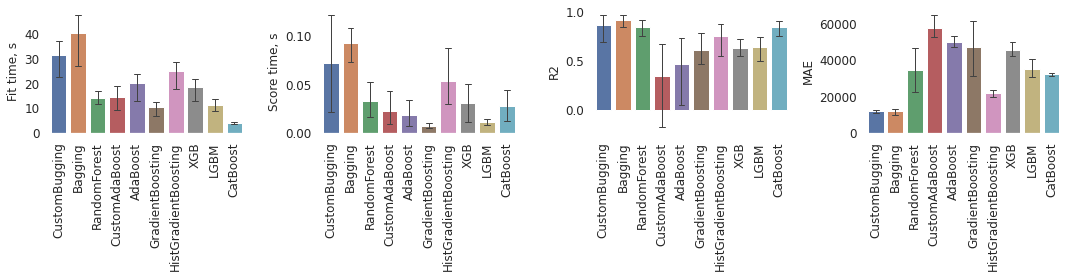

In [266]:
results = pd.read_csv(pathlib.Path("optuna_res.csv"))
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))

for y, ax in zip(["Fit time, s", "Score time, s", "R2", "MAE"], axs.flatten()):
    sns.barplot(results[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

Исходя из графиков, заключаем, что лучшая точность предсказаний у Bagging и CustomBagging и худшая у CustomAdaBoost и AdaBoost 